In [405]:
import tensorflow as tf

print(tf.__version__)
print(tf.keras.__version__)
from matplotlib import pyplot as plt
import os
import random
import matplotlib.pyplot as pltBVGGBHBNM
import os

import time
import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm
import numpy as np
from datetime import datetime
from datetime import datetime

2.12.0
2.12.0


In [406]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

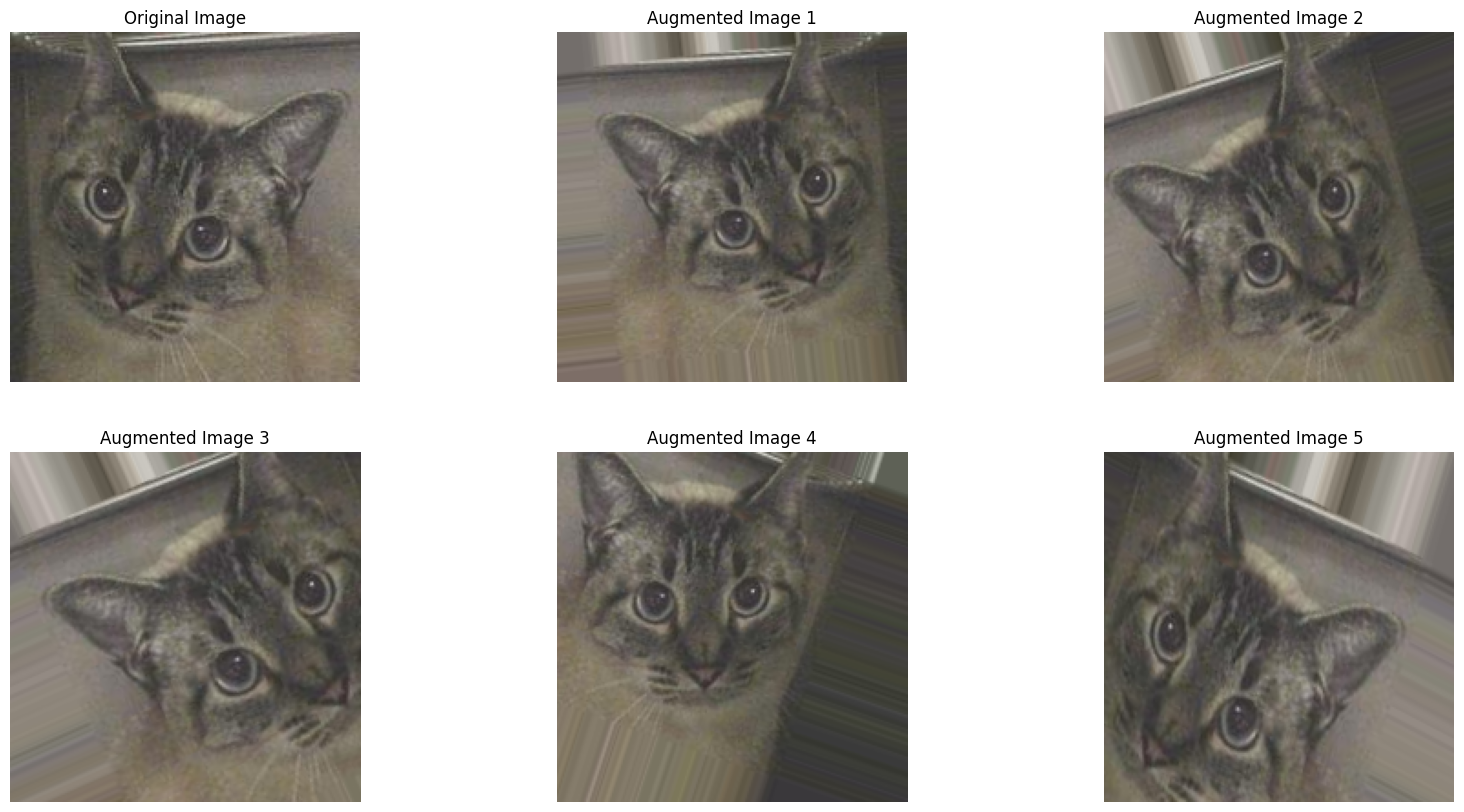

In [407]:
fig, ax = plt.subplots(2,3,figsize=(20,10))
all_images = []

dog_image_dir = 'Dataset/PetImages/Train/Cat/'
dog_images = []
_, _, dog_images = next(os.walk('Dataset/PetImages/Train/Cat/'))
            
random_img = random.sample(dog_images,1)[0]
random_img = plt.imread('Dataset/PetImages/Train/Cat/'+random_img)
all_images.append(random_img)

random_img = random_img.reshape((1,)+random_img.shape)
sample_augmented_images = image_generator.flow(random_img)

for _ in range(5):
    augmented_imgs = sample_augmented_images.next()
    for img in augmented_imgs:
        all_images.append(img.astype('uint8'))

for idx, img in enumerate(all_images):
    ax[int(idx/3),idx%3].imshow(img)
    ax[int(idx/3),idx%3].axis('off')
    if idx == 0:
        ax[int(idx/3), idx%3].set_title('Original Image')
    else: 
        ax[int(idx/3), idx%3].set_title('Augmented Image {}'.format(idx))

plt.show()


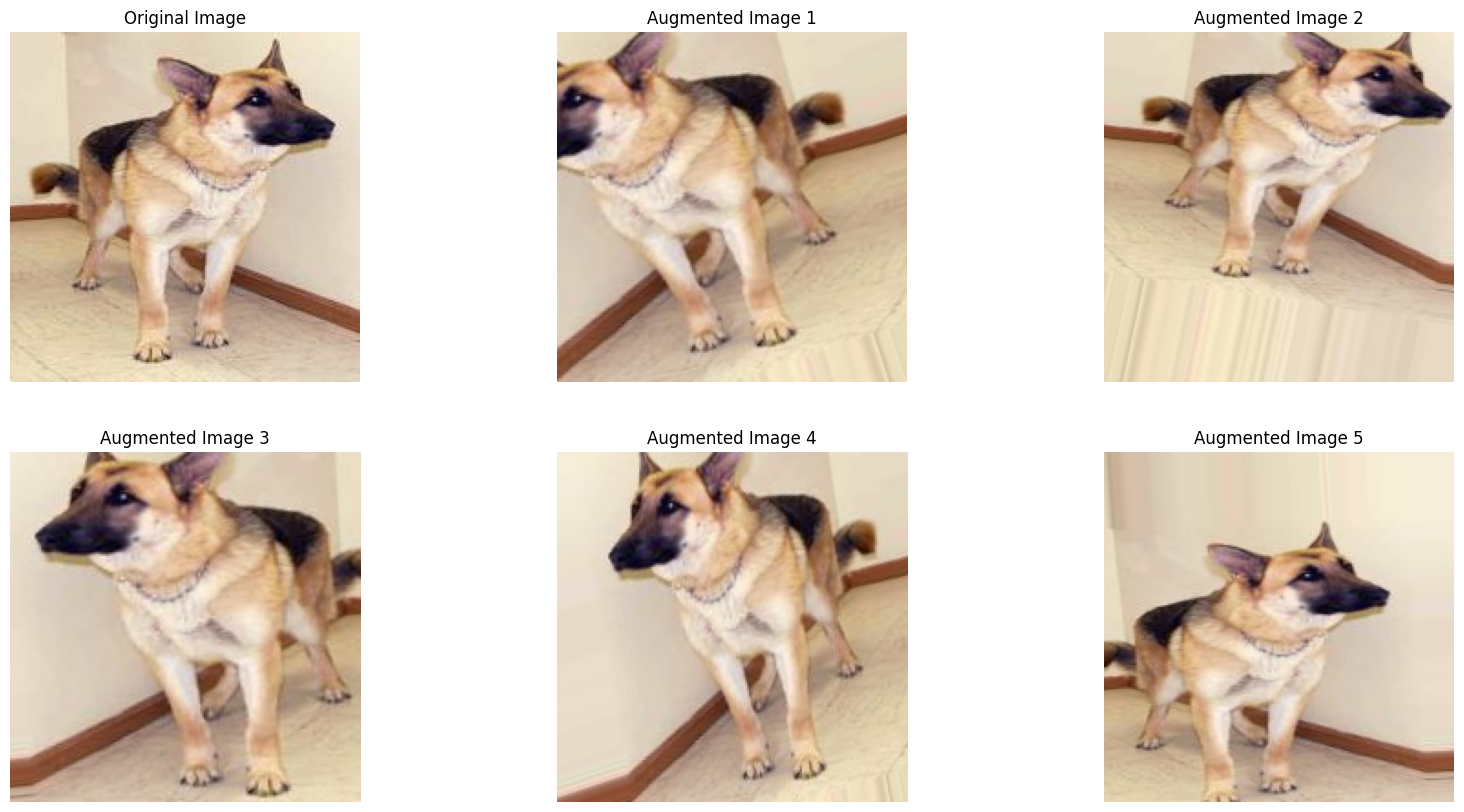

In [408]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
all_images = []

dog_image_dir = "Dataset/PetImages/Train/Dog/"
dog_images = []
_, _, dog_images = next(os.walk("Dataset/PetImages/Train/Dog/"))

random_img = random.sample(dog_images, 1)[0]
random_img = plt.imread("Dataset/PetImages/Train/Dog/" + random_img)
all_images.append(random_img)

random_img = random_img.reshape((1,) + random_img.shape)
sample_augmented_images = image_generator.flow(random_img)

for _ in range(5):
    augmented_imgs = sample_augmented_images.next()
    for img in augmented_imgs:
        all_images.append(img.astype("uint8"))

for idx, img in enumerate(all_images):
    ax[int(idx / 3), idx % 3].imshow(img)
    ax[int(idx / 3), idx % 3].axis("off")
    if idx == 0:
        ax[int(idx / 3), idx % 3].set_title("Original Image")
    else:
        ax[int(idx / 3), idx % 3].set_title("Augmented Image {}".format(idx))

plt.show()

In [411]:
INPUT_SIZE = 32
MAXPOOL_SIZE = 2
BATCH_SIZE = 32
IMAGE_SIZE = (192, 192)



train_dataset = tf.keras.utils.image_dataset_from_directory(
    "Dataset/PetImages/Train/",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=999,
    validation_split=0.20,
    subset="training",
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "Dataset/PetImages/Test/",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=999,
    validation_split=0.20,
    subset="validation",
)
class_names = train_dataset.class_names

Found 6194 files belonging to 2 classes.
Using 4956 files for training.
Found 3634 files belonging to 2 classes.
Using 726 files for validation.


In [412]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [413]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [414]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal_and_vertical'),
        tf.keras.layers.RandomRotation(0.3),
        tf.keras.layers.RandomZoom(0.2)
    ])

In [415]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [416]:

IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
)

In [417]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [418]:
try:
    image_batch, label_batch = next(iter(train_dataset))

except Exception as e:
    print(f"Error processing image: {e}")
    
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False

(32, 6, 6, 1280)


In [419]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 96, 96, 32)   864         ['input_28[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 96, 96, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 96, 96, 32)   0           ['bn_Conv1[0][

In [420]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) 
model = tf.keras.Model(inputs, outputs)

In [421]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [422]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 192, 192, 3)]     0         
                                                                 
 sequential_22 (Sequential)  (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv_10 (TFOpLam  (None, 192, 192, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_10 (TFOpLa  (None, 192, 192, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                          

In [423]:
initial_epochs =20

loss0, accuracy0 = model.evaluate(validation_dataset)

19/19 [==============================] - 10s 426ms/step - loss: 0.9076 - accuracy: 0.3361


In [424]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.91
initial accuracy: 0.34


In [425]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
155/155 [==============================] - 88s 536ms/step - loss: 0.7056 - accuracy: 0.5973 - val_loss: 0.5415 - val_accuracy: 0.7358
Epoch 2/20
155/155 [==============================] - 82s 528ms/step - loss: 0.5117 - accuracy: 0.7526 - val_loss: 0.3427 - val_accuracy: 0.9097
Epoch 3/20
155/155 [==============================] - 80s 514ms/step - loss: 0.4043 - accuracy: 0.8220 - val_loss: 0.2403 - val_accuracy: 0.9431
Epoch 4/20
155/155 [==============================] - 82s 528ms/step - loss: 0.3688 - accuracy: 0.8398 - val_loss: 0.1813 - val_accuracy: 0.9582
Epoch 5/20
155/155 [==============================] - 86s 554ms/step - loss: 0.3394 - accuracy: 0.8493 - val_loss: 0.1646 - val_accuracy: 0.9599
Epoch 6/20
155/155 [==============================] - 85s 551ms/step - loss: 0.3162 - accuracy: 0.8656 - val_loss: 0.1386 - val_accuracy: 0.9666
Epoch 7/20
155/155 [==============================] - 85s 548ms/step - loss: 0.3062 - accuracy: 0.8680 - val_loss: 0.1365 - val_ac

In [427]:

date = datetime.now().strftime('%Y%m%d%H%M%S')
model.save('model/my_model' + date + '.h5') # creates a HDF5 file

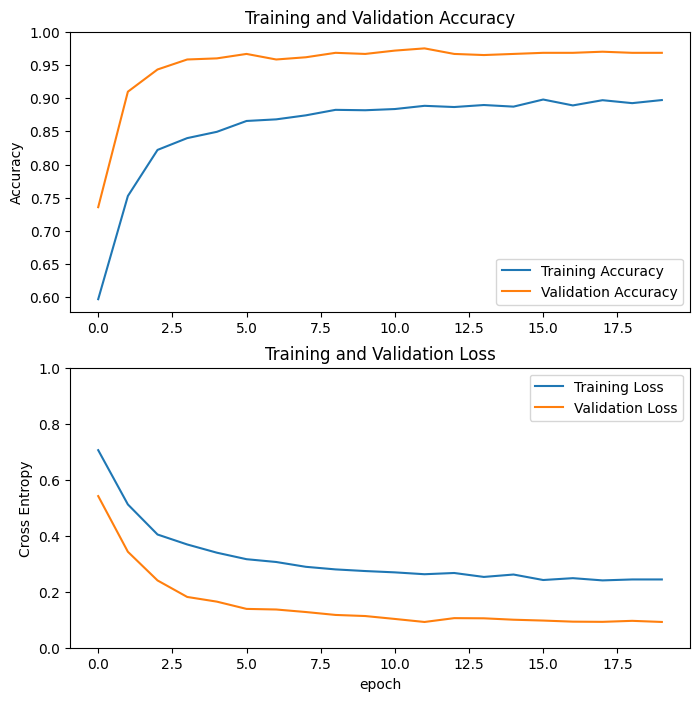

In [428]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [429]:
base_model.trainable = True
print(base_model.trainable)

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = -10

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

True
Number of layers in the base model:  154


In [430]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [431]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 192, 192, 3)]     0         
                                                                 
 sequential_22 (Sequential)  (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv_10 (TFOpLam  (None, 192, 192, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_10 (TFOpLa  (None, 192, 192, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                          

In [432]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/30
155/155 [==============================] - 101s 620ms/step - loss: 0.2228 - accuracy: 0.9058 - val_loss: 0.0828 - val_accuracy: 0.9682
Epoch 21/30
155/155 [==============================] - 93s 601ms/step - loss: 0.2141 - accuracy: 0.9066 - val_loss: 0.0784 - val_accuracy: 0.9699
Epoch 22/30
155/155 [==============================] - 92s 594ms/step - loss: 0.1996 - accuracy: 0.9169 - val_loss: 0.0771 - val_accuracy: 0.9699
Epoch 23/30
155/155 [==============================] - 90s 584ms/step - loss: 0.1971 - accuracy: 0.9181 - val_loss: 0.0864 - val_accuracy: 0.9716
Epoch 24/30
155/155 [==============================] - 94s 606ms/step - loss: 0.1955 - accuracy: 0.9191 - val_loss: 0.0706 - val_accuracy: 0.9732
Epoch 25/30
155/155 [==============================] - 92s 592ms/step - loss: 0.1838 - accuracy: 0.9243 - val_loss: 0.0542 - val_accuracy: 0.9732
Epoch 26/30
155/155 [==============================] - 89s 572ms/step - loss: 0.1867 - accuracy: 0.9187 - val_loss: 0.0706 

In [ ]:
date = datetime.now().strftime('%Y%m%d%H%M%S')
model.save('finetune/my_model' + date + '.h5') # creates a HDF5 file

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

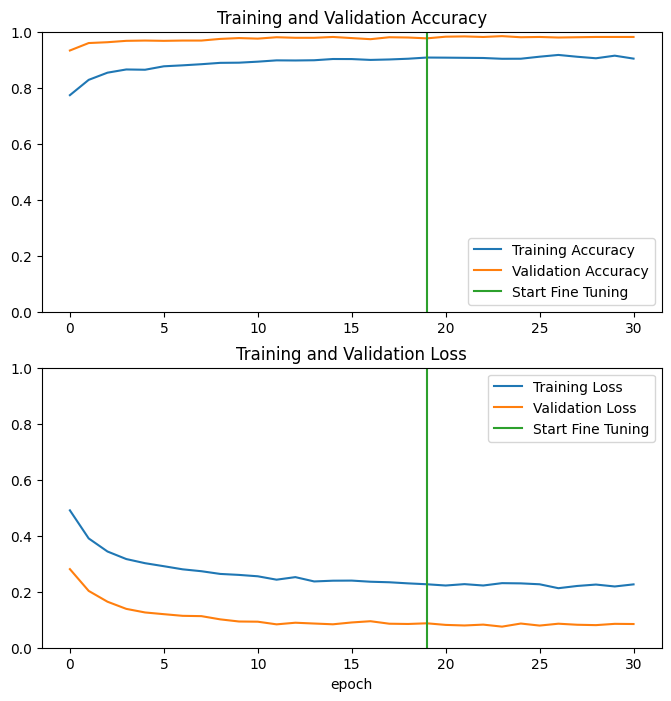

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 4s 481ms/step - loss: 0.1149 - accuracy: 0.9732
Test accuracy : 0.9732142686843872


Confusion Matrix:
 [[15  0]
 [ 0 17]]


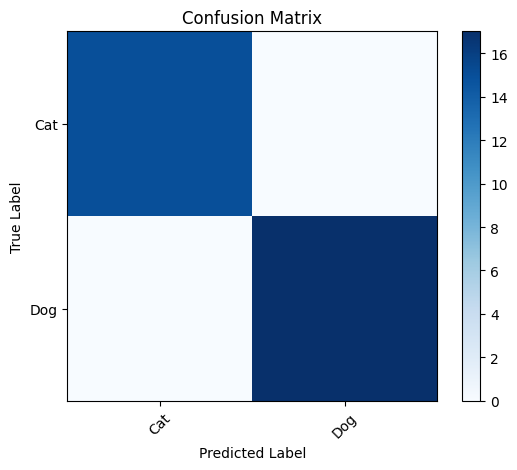

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# Retrieve a batch of images from the test set
image_batch, label_batch = train_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

# Convert predictions to numpy array
predictions = np.array(predictions)

# Compute confusion matrix
cm = confusion_matrix(label_batch, predictions)

# Print confusion matrix
print('Confusion Matrix:\n', cm)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Predictions:
 [0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
Labels:
 [0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]


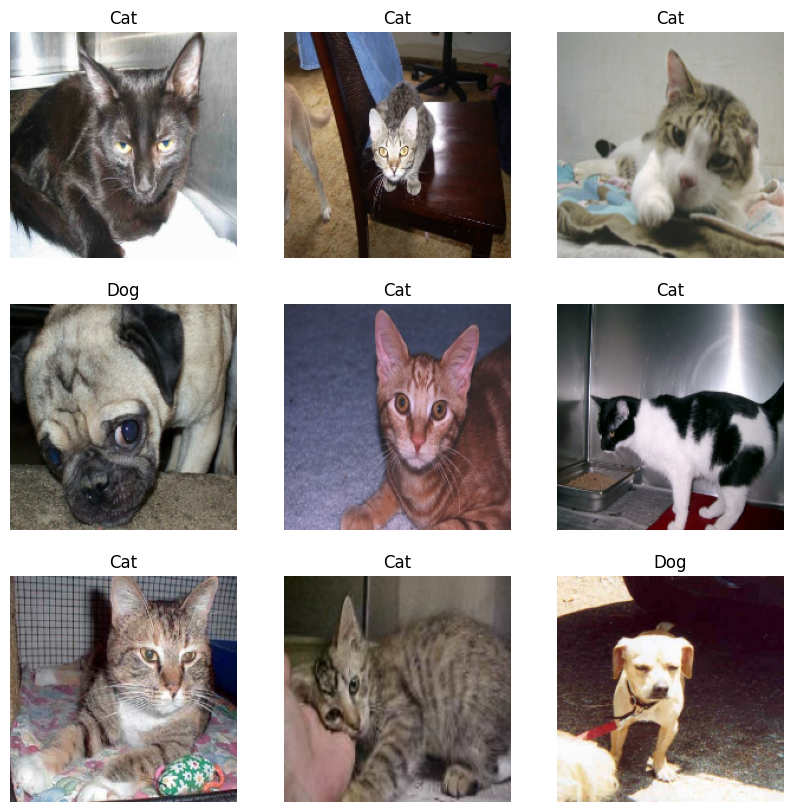

In [426]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")